<a href="https://colab.research.google.com/github/GuilhermeHachimine/Collab/blob/main/soja_predicting_price_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pandas_datareader
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [12]:
data = pd.read_csv('cepea.csv')
data.head()

,date,price BRL,price USD
0,01/12/2021,"162,14","28,62"
1,02/12/2021,"163,82","28,98"
2,03/12/2021,"165,69","29,19"
3,06/12/2021,"166,33","29,25"
4,07/12/2021,"165,07","29,38"


In [17]:
data["price BRL"] = data["price BRL"].astype(str).str.replace(',', '.')

data["price USD"] = data["price USD"].astype(str).str.replace(',', '.')

display(data)

,date,price BRL,price USD,price
0,01/12/2021,162.14,28.62,162.14
1,02/12/2021,163.82,28.98,163.82
2,03/12/2021,165.69,29.19,165.69
3,06/12/2021,166.33,29.25,166.33
4,07/12/2021,165.07,29.38,165.07
...,...,...,...,...
246,25/11/2022,181.43,33.54,181.43
247,28/11/2022,181.34,33.79,181.34
248,29/11/2022,181.13,34.23,181.13
249,30/11/2022,179.50,34.45,179.50


In [18]:
data_to_train = data[:200]
data_to_test = data[200:]

In [19]:
data_to_train.to_csv('train_data.csv')
data_to_test.to_csv('test_data.csv')

In [20]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [21]:
#Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['price BRL'].values.reshape(-1,1))

In [22]:
prediction_days = 1

x_train=[]
y_train=[]

In [24]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


In [26]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [27]:
#Build the Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) 
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=200, batch_size=32)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                

In [28]:
actual_prices = test_data['price BRL'].values
total_dataset = pd.concat((train_data['price BRL'], test_data['price BRL']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [29]:
# Make Predictions on Test Data
x_test=[]
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)


2/2 [==============================] - 1s 7ms/step


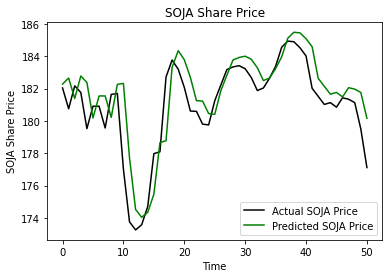

In [30]:
# Plot the test predictions
plt.plot(actual_prices, color = "black", label=f"Actual SOJA Price")
plt.plot(predicted_prices, color="green", label=f"Predicted SOJA Price")
plt.title(f"SOJA Share Price")
plt.xlabel("Time")
plt.ylabel(f"SOJA Share Price")
plt.legend()
plt.show()


In [32]:
#Predict Next Day
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")
print(f"Last price",scaler.inverse_transform(x_test[-1]))

1/1 [==============================] - 0s 87ms/step
Prediction: [[177.81175]]
Last price [[179.5]]
